# Three wheeled robot: problem description
$
%%%%PREAMBLE%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Arrow notation
\newcommand{\ra}{\rightarrow}
\newcommand{\rra}{\rightrightarrows}
\newcommand{\la}{\leftarrow}
% \newcommand{\red}[1]{\textcolor{red}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Abbreviations
\newcommand{\ie}{\unskip, i.\,e.,\xspace}
\newcommand{\eg}{\unskip, e.\,g.,\xspace}
\newcommand{\pd}{p.\,d.\xspace}
\newcommand{\sut}{\text{s.\,t.\,}}
\newcommand{\rt}{r.\,t.\xspace}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Wraps
\newcommand{\nrm}[1]{\left\lVert#1\right\rVert}
\newcommand{\diag}[1]{{\text{diag}}\left(#1\right)}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\scal}[1]{\left\langle#1\right\rangle}
\newcommand{\tr}[1]{{\text{tr}}\left(#1\right)}
\newcommand{\E}[1]{\mathbb E\left[#1\right]}
\newcommand{\PP}[1]{\mathbb P\left[#1\right]}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Set notation
\renewcommand{\N}{{\mathbb{N}}}
\renewcommand{\Z}{{\mathbb{Z}}}
\newcommand{\Q}{{\mathbb{Q}}}
\renewcommand{\R}{{\mathbb{R}}}
\newcommand{\T}{{\mathbb{T}}}
\newcommand{\X}{{\mathbb{X}}}
\newcommand{\Y}{{\mathbb{Y}}}
\newcommand{\F}{{\mathbb{F}}}
\newcommand{\U}{{\mathbb{U}}}
%\renewcommand{\U}{{\mathbb{U}}}
\newcommand{\sm}{{\setminus}}
\renewcommand{\set}[1]{{\mathbb{#1}}}
% \let\oldemptyset\emptyset
% \let\emptyset\varnothing
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Colored
% \newcommand{\red}[1]{\textcolor{red}{#1}}
% \newcommand{\blue}[1]{\textcolor{blue}{#1}}
% \definecolor{dgreen}{rgb}{0.0, 0.5, 0.0}
% \newcommand{\green}[1]{\textcolor{dgreen}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Miscellaneous commands
\newcommand{\diff}{\mathop{}\!\mathrm{d}}
\newcommand{\eps}{{\varepsilon}}
\newcommand{\sgn}{{\text{sgn}}}
\newcommand{\spc}{{\,\,}}
\newcommand{\diam}{{\text{diam}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\ramp}{{\text{ramp}}}
\newcommand{\pdiff}[2]{ { \frac{\partial {#1}}{\partial {#2}} } }
\newcommand{\ball}{{\mathcal B}}
% \newcommand\circled[1]{\tikz[baseline=(char.base)]{\node[shape=circle,draw,inner sep=1pt](char){#1};}}
\newcommand{\co}{{\overline{\text{co}}}}
% \newcommand{\argmin}{\arg\min}
% \newcommand{\argmax}{arg\,max}
\newcommand{\lineZ}{\overline{Z}}
\newcommand{\lineR}{\overline{R}}
\newcommand{\linez}{\overline{z}}
\newcommand{\EP}[2]{\mathbb E_{#1}\left[#2\right]}
$

Here we consider a learning control for three wheeled robot described by:
$$
    \begin{aligned}
        &  \dot{x}_{\text{rob}} = v \cos(\vartheta), \\
        &  \dot{y}_{\text{rob}} = v \sin(\vartheta), \\
        & \dot{\vartheta} = \omega.
    \end{aligned}
    \qquad v \in [v_{\min}, v_{\max}], \quad \omega \in [\omega_{\min}, \omega_{\max}]
$$
where robot speed $v$ and anglular speed $\omega$ are control variables.
We assume the starting position of robot is as follows:
$$
    \begin{aligned}
        & {x}_{\text{rob}}(0) = 2 \\
        & {y}_{\text{rob}}(0) = 2 \\
        & \vartheta(0) = \frac{3\pi}{4}
    \end{aligned}    
$$


The formal goal of control reads:
$$
    {x}_{\text{rob}} \ra 0 \qquad  {y}_{\text{rob}}  \ra 0 \qquad \vartheta \ra 0
$$

To assess the performance of our learned policy, we will penalize it by a running cost function as follows:

$$
r({x}_{\text{rob}}, {y}_{\text{rob}}, \vartheta, v, \omega) = |{x}_{\text{rob}}| + |{y}_{\text{rob}}| +  |\vartheta|
$$

**Remark 1**

In reward maximization problems, $r$ is called a reward, rather than cost.
However, in this notebook we denote $r$ as cost function. This changes almost nothing for us, because one can easily
transform any reward function $r$ to the cost function via putting $r := -r$ and vice versa.

**Remark 2**

In general $r(\cdot)$ can depend on $u = (v, \omega)$, but in our case we do not put cost on action $u$.

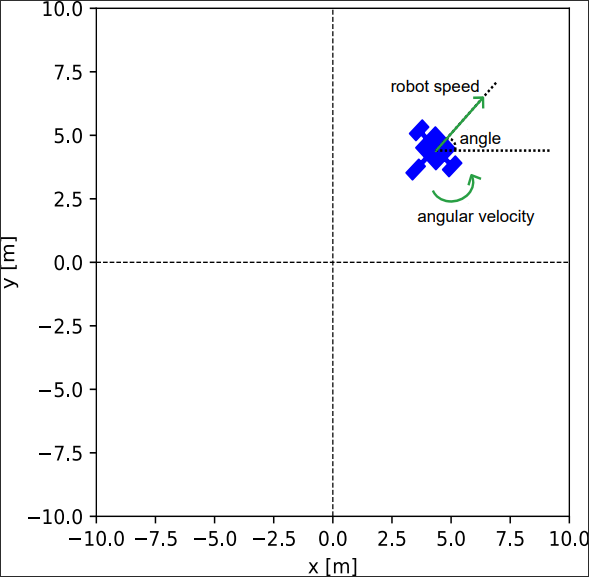

## Environment

$$
    x_{k+1} = f(x_k, u_k), \quad y_k = h(x_k), \quad u_k = \rho^{\theta}(y_k)
$$
where
1. $x_k$ is a state $(x_{\text{rob}}, y_{\text{rob}}, \vartheta)$ on step k
2. $u_k$ is an action $(v, \omega)$ on step $k$
3. $y_k$ is observation. In our case $h = \text{id}$, so in further text we will use $y$ and $x$ interchangebaly since they are identical.
4. $f$ is transition function. In our case int is the Euler integrator for robot system defined above.
5. $\rho^{\theta}$ is a policy. It is defined [below](#policy).

## Critic

In reinforcement learning algorithms critic is used for helping the policy (a.k.a. actor) to stabilize the system. This goal is achieved via running consequent optimization procedures for critic and policy. Thus, critic and policy are two entities that take turns in helping each other to achieve a common goal.

Critic model will be taken as perceptron $\hat{J}^{w}(y)$ with weights $w$ which approximates the so-called optimal cost-to-go $J^*(y)$, i.e. the function that equals the expected value of discounted sum of infinite number costs with $y$ taken as intitial observation with further applying of optimal policy $\rho^{*}$ for infinite number of times. Strictly speaking,
$$
     J^*(y) = \min_{\rho}\left[\sum_{k = 0}^{\infty} \gamma ^ k r(y_k, u_k)\right] \text{ subject to } y_0 = y,
$$
where $\gamma \in [0,1]$ is a *discount factor* and should be interpreted as hyperparameter of algorithm.

Note that

$$
     \rho^{*}(y) = \arg\left(\min_{\rho}\left[\sum_{k = 0}^{\infty} \gamma ^ k r(y_k, u_k)\right] \text{ subject to } y_0 = y\right)
$$

We update critic weights on every simulator step $k$ via gradient descent procedure

> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Critic}} \}$:
>> $
    w^{\text{new}} \la w^{\text{old}} -  \eta \nabla_{w}\left(\frac{\sum\limits_{k' = k + 1 - B}^{k - N_{\text{TD}}} \left(\hat{J}^{w}\left(y_{k'}\right) - r\left(y_{k'}, u_{k'}\right) - \gamma r\left(y_{k'+1}, u_{k'+1}\right) -... - \gamma^{N_{\text{TD}}-1} r\left(y_{k' + N_{\text{TD}}-1}, u_{k' + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{J}^{w}\left(y_{k' + N_{\text{TD}}}\right)\right) ^ 2}{B-1-N_{\text{TD}}}\right)\bigg|_{w = w^{\text{old}}}
$


where $B$ is batch size and $N_{\text{epochs}}^{\text{Critic}}$ is small, say, 1 or 2.

The notes about theoretical convergence of $\hat{J}^{w}(y) \ra J^*(y)$ is provided [below](#critic-convergence).

## Policy

Let us define the policy as:
$$
    \rho^{\theta}(y) = \theta
$$
We generate action on every step $k$ as follows. Firstly, we toss the assymetric coin $P \sim \text{Bernoulli}(\eps)$, where $\eps$, say, $\eps = 0.05$. If $P = 1$, then we sample random action from
$$
    u_k \sim \text{Uniform}([v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}])
$$
If $P = 0$ then we put
$$
    u_k =  \arg\left(\min_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\text{ subject to } \rho^{\theta}(y) \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right),
$$
where we denoted $y_{k+1}^{\rho^{\theta}(y)}$ the observation that is derived via applying action $\rho^{\theta}(y)$ to $y$:
$$
    y_{k+1}^{\rho^{\theta}(y)} = f(y_k, \rho^{\theta}(y)).
$$
The approach is called **exploration**. It forces agent to make unpredictable actions in  $100\eps$% of steps to enrich experience replay. This approach is fully heruistic and doesn't have any theoretical evidence. But on pratice it works and the main idea of it: do not let the critic fall into local mininum.

**Remark**
There is no mistake here. We indeed define the policy model as $\rho^{\theta}(y) = \theta$. Note that if we substitute it into
$$
u_k =  \arg\left(\min_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\text{ subject to } \rho^{\theta}(y) \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right)
$$
and redefine the notation $u := \theta$, then
$$
u_k =  \arg\left(\min_{u}\left(r(y_k, u) + \gamma \hat{J}^{w}(y_{k+1}^{u})\right)\text{ subject to } u \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right).
$$


## Online Actor-Critic algorithm

You can find the notes above convergence of the algorithm [below](#critic-convergence):


> **for** j in $\{1, \dots, M\}$: ($j$ is the number of episode):
>>
>> - obtain observation $y_k$ from the system
>> - fit critic $\hat{J}^{w}$
>> - sample action $u_k = \begin{cases} \text{Uniform}([v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]), \text{ if } P = 1 \\  \arg\left(\min_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\text{ subject to } \rho^{\theta}(y) \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right), \text{ if } P = 0\end{cases}$
>>
>> where $P \sim \text{Bernoulli}(\eps)$

We fit critic as follows:

> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Critic}} \}$:
>> $
    w^{\text{new}} \la w^{\text{old}} -  \eta \nabla_{w}\left(\frac{\sum\limits_{k' = k + 1 - B}^{k - N_{\text{TD}}} \left(\hat{J}^{w}\left(y_{k'}\right) - r\left(y_{k'}, u_{k'}\right) - \gamma r\left(y_{k'+1}, u_{k'+1}\right) -... - \gamma^{N_{\text{TD}}-1} r\left(y_{k' + N_{\text{TD}}-1}, u_{k' + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{J}^{w}\left(y_{k' + N_{\text{TD}}}\right)\right) ^ 2}{B-1-N_{\text{TD}}}\right)\bigg|_{w = w^{\text{old}}}
$
>>
>> where $B$ is batch size and $N_{\text{epochs}}^{\text{Critic}}$ is small, say, 1 or 2.

We find $\arg\left(\min_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\text{ subject to } \rho^{\theta}(y) \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right)$ via gradient descent algorithm

> Set initial $\theta \la 0$
>
> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Policy}} \}$:
>> - $\theta^{\text{new}} \la \theta^{\text{old}} -  \alpha \nabla_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\bigg|_{\theta = \theta^{\text{old}}}$
>>
>> - clip $\rho^{\theta^{\text{new}}}(y) = \theta^{\text{new}}$ to $[v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]$



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any, Union
from IPython.display import clear_output

# Problem 1. Implement right-hand side of three wheeled robot  system

$$
\begin{aligned}
        &  \dot{x}_{\text{rob}} = v \cos(\vartheta), \\
        &  \dot{y}_{\text{rob}} = v \sin(\vartheta), \\
        & \dot{\vartheta} = \omega.
    \end{aligned}
$$

In [2]:
class ThreeWheeledRobotSystem:
    """System class: inverted pendulum. State transition function"""

    dim_action: int = 2
    dim_observation: int = 3
    dim_state: int = 3

    def __init__(self) -> None:
        """Initialize `InvertedPendulumSystem`"""

        self.reset()

    def reset(self) -> None:
        """Reset system to inital state."""

        self.action = np.zeros(self.dim_action)

    def compute_dynamics(
        self,
        state: Union[np.array, torch.FloatTensor],
        action: Union[np.array, torch.FloatTensor],
    ) -> Union[np.array, torch.FloatTensor]:
        """Calculate right-hand-side for Euler integrator

        Args:
            state (np.array): current state
            action (np.array): current action

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        if isinstance(state, np.ndarray):
            backend = np
        else:
            backend = torch

        Dstate = backend.zeros(self.dim_state)

        # -----------------------------------------------------------------------
        # HINT
        # Assume that Dstate is the right-hand side of the system dynamics
        # description, and assign proper values to the components of Dstate,
        # assuming that:
        #
        Dstate[0] = action[0] * np.cos(state[-1])
        Dstate[1] = action[0] * np.sin(state[-1])
        Dstate[2] = action[1]

        # for taking the cos use backend.cos(...)
        # for sin use backend.sin(...)

        # YOUR CODE GOES HERE

        # -----------------------------------------------------------------------

        return Dstate

    def compute_closed_loop_rhs(self, state: np.array) -> np.array:
        """Get right-hand-side for current observation and saved `self.action`

        Args:
            state (np.array): current state

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        system_right_hand_side = self.compute_dynamics(state, self.action)
        return system_right_hand_side

    def receive_action(self, action: np.array) -> None:
        """Save current action to `self.action`

        Args:
            action (np.array): current action
        """

        self.action = action

    @staticmethod
    def get_observation(state: np.array) -> np.array:
        """Get observation given a state

        Args:
            state (np.array): system state

        Returns:
            np.array: observation
        """
        observation = state

        return observation

## Simulator

Here we implement the Euler numerical integration scheme for our system.

In [3]:
class Simulator:
    """Euler integrator"""

    def __init__(
        self,
        system: ThreeWheeledRobotSystem,
        N_steps: int,
        step_size: float,
        state_init: np.array,
    ):
        self.system = system
        self.N_steps = N_steps
        self.step_size = step_size
        self.state = np.copy(state_init)
        self.state_init = np.copy(state_init)
        self.current_step_idx = 0

    def step(self) -> bool:
        """Do one Euler integration step

        Returns:
            bool: status of simulation. `True` - simulation continues, `False` - simulation stopped
        """

        if self.current_step_idx <= self.N_steps:
            self.state += (
                self.system.compute_closed_loop_rhs(self.state) * self.step_size
            )
            self.current_step_idx += 1
            return True
        else:
            return False

    def reset(self) -> None:
        """Resets the system to initial state"""

        self.state = np.copy(self.state_init)
        self.current_step_idx = 0
        self.system.reset()

    def get_sim_step_data(self) -> Tuple[np.array, np.array, int]:
        """Get current observation, action and step id

        Returns:
            Tuple[np.array, np.array, int]:
        """

        return (
            self.system.get_observation(self.state),
            np.copy(self.system.action),
            int(self.current_step_idx),
        )

# Problem 1.2. Test your results

You have implemented the three wheeled robot system. **Verify** that you have
done everything right. Compare your results with picture below. It should look exactly the same!

![image.png](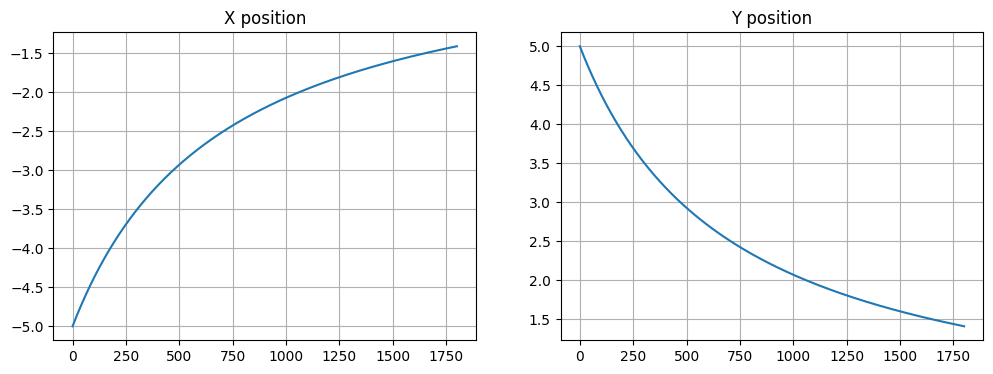
)

Text(0.5, 1.0, 'Y position')

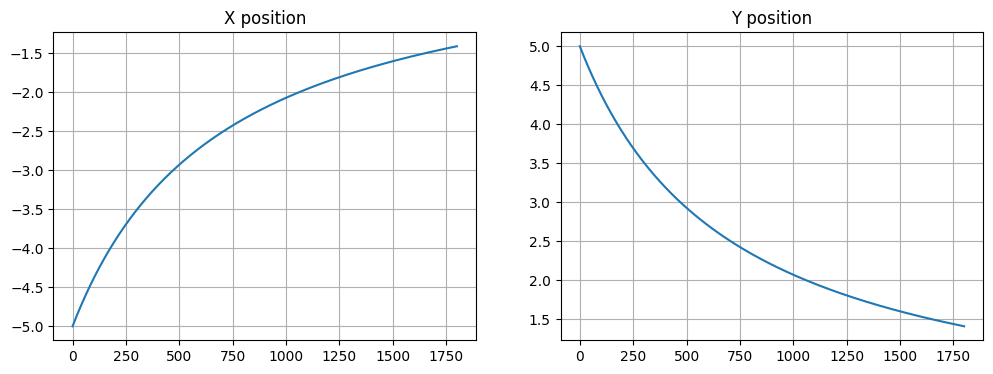

In [4]:
# ------------------------------------------------------------------------------
# RUN THIS!
system = ThreeWheeledRobotSystem()
simulator = Simulator(
    system,
    N_steps=1800,
    step_size=0.0001,
    state_init=np.array([-5.0, 5.0, 3 * np.pi / 4]),
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array(
        [
            -2 * observation[0] ** 2 - 2 * observation[1] ** 2,
            0,
        ]
    )

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("X position")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Y position")
# ------------------------------------------------------------------------------

# Problem 1.3. Test your results

You have implemented the three wheeled robot system. **Verify** that you have
done everything right. Run the code below and check that `Success!` is printed

In [5]:
# -------------------------------------------------------------------------------------
# Run this and verify that Success is printed

try:
    torch_output = system.compute_dynamics(
        torch.tensor([2.0, -2.0, 0.0]), torch.tensor([10.0, 5.0])
    )
    if not isinstance(torch_output, torch.Tensor):
        raise ValueError("")

    numpy_output = system.compute_dynamics(
        np.array([2.0, -2.0, 0.0]), np.array([10.0, 5.0])
    )

    if not isinstance(numpy_output, np.ndarray):
        raise ValueError("")

    print("Success!")
except:
    print(
        "You have done something wrong. In this howework the torch (numpy) input should provide torch (numpy) output"
    )
# -----------------------------------------------------------------------------------------

Success!


## Experience replay

In this section we implement ta data buffer to store past observations, actions,
running costs, running total costs.

For this purpose, we implement `class DataBuffer`. The functionality for sampling from it is also provided. There is no need to understand the code. We provide the interface for `DataBuffer` [below](#databufferinterface). There is no need to understand the interface too. We provide the explanation here only to satisfy your curiosity.

In [6]:
from abc import ABC, abstractmethod
from typing import Optional, List, Dict, Union, Iterable
from collections import defaultdict
import numpy as np
from typing import Union, Type


class FifoList(list):
    """Fifo list class. Acts like list but when size exceeds max_size it removes the first element."""

    def __init__(self, *args, max_size: Optional[int] = None, **kwargs):
        """Instantiate a FifoList.

        :param max_size: maximum size of the list. If `None` the list is not limited in size, defaults to None
        :type max_size: Optional[int], optional
        """
        super().__init__(*args, **kwargs)
        self.max_size = max_size

    def append(self, item: Any) -> None:
        super().append(item)
        if self.max_size is not None:
            if len(self) > self.max_size:
                self.pop(0)


RgArrayType = Union[
    Type[np.array],
    Type[torch.Tensor],
    Type[torch.FloatTensor],
    Type[torch.DoubleTensor],
    Type[torch.LongTensor],
]

RgArray = Union[
    FifoList,
    np.array,
    torch.Tensor,
    torch.FloatTensor,
    torch.DoubleTensor,
    torch.LongTensor,
]

import numpy as np
import torch


from typing import Any, Optional


class BatchSampler(ABC):
    """Base class for batch samplers."""

    def __init__(
        self,
        data_buffer,
        keys: Optional[List[str]],
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a BatchSampler.

        :param data_buffer: Data Buffer instance
        :type data_buffer: DataBuffer
        :param keys: keys to sample
        :type keys: Optional[List[str]]
        :param dtype: dtype for sample, can be either cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: device for sampling, needed for torch.FloatTensor defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional, defaults to 0.0
        """
        self.keys = keys
        self.dtype = dtype
        self.data_buffer = data_buffer
        self.data_buffer.set_indexing_rules(
            keys=self.keys, dtype=self.dtype, device=device, fill_na=fill_na
        )
        self.len_data_buffer = len(self.data_buffer.data[self.keys[0]])
        self.device = device
        for k in self.keys:
            assert self.len_data_buffer == len(
                self.data_buffer.data[k]
            ), "All keys should have the same length in Data Buffer"

    def __iter__(self):
        if self.stop_iteration_criterion():
            self.nullify_sampler()
        return self

    def __next__(self):
        if self.stop_iteration_criterion():
            raise StopIteration
        return self.next()

    @abstractmethod
    def next(self) -> Dict[str, RgArray]:
        pass

    @abstractmethod
    def nullify_sampler(self) -> None:
        pass

    @abstractmethod
    def stop_iteration_criterion(self) -> bool:
        pass


class RollingBatchSampler(BatchSampler):
    """Batch sampler for rolling batches."""

    def __init__(
        self,
        mode: str,
        data_buffer,
        keys: Optional[List[str]],
        batch_size: Optional[int] = None,
        n_batches: Optional[int] = None,
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a RollingBatchSampler.

        :param mode: mode for batch sampling. Can be either 'uniform', 'backward', 'forward', 'full'. 'forward' for sampling of rolling batches from the beginning of DataBuffer. 'backward' for sampling of rolling batches from the end of DataBuffer. 'uniform' for sampling random uniformly batches. 'full' for sampling the full DataBuffer
        :type mode: str
        :param data_buffer: DataBuffer instance
        :type data_buffer: DataBuffer
        :param keys: DataBuffer keys for sampling
        :type keys: Optional[List[str]]
        :param batch_size: batch size, needed for 'uniform', 'backward', 'forward', defaults to None
        :type batch_size: Optional[int], optional
        :param n_batches: how many batches to sample, can be used for all modes. Note that sampling procedure stops in case if DataBuffer is exhausted for 'forward' and 'backward' modes,  defaults to None
        :type n_batches: Optional[int], optional
        :param dtype: dtype for sampling, can be either of cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: device to sample from, defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional
        """
        if batch_size is None and mode in ["uniform", "backward", "forward"]:
            raise ValueError(
                "batch_size should not be None for modes ['uniform', 'backward', 'forward']"
            )
        assert mode in [
            "uniform",
            "backward",
            "forward",
            "full",
        ], "mode should be one of ['uniform', 'backward', 'forward', 'full']"
        assert not (
            n_batches is None and (mode == "uniform" or mode == "full")
        ), "'uniform' and 'full' mode are not avaliable for n_batches == None"

        BatchSampler.__init__(
            self,
            data_buffer=data_buffer,
            keys=keys,
            dtype=dtype,
            device=device,
            fill_na=fill_na,
        )
        self.mode = mode
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.n_batches_sampled: int
        self.nullify_sampler()

    def nullify_sampler(self) -> None:
        self.n_batches_sampled = 0
        if self.mode == "forward":
            self.batch_ids = np.arange(self.batch_size, dtype=int)
        elif self.mode == "backward":
            self.batch_ids = np.arange(
                self.len_data_buffer - self.batch_size,
                self.len_data_buffer,
                dtype=int,
            )
        elif self.mode == "uniform":
            self.batch_ids = np.random.randint(
                low=0,
                high=max(self.len_data_buffer - self.batch_size, 1),
            ) + np.arange(self.batch_size, dtype=int)
        elif self.mode == "full":
            self.batch_ids = np.arange(self.len_data_buffer, dtype=int)
        else:
            raise ValueError("mode should be one of ['uniform', 'backward', 'forward']")

    def stop_iteration_criterion(self) -> bool:
        if self.mode != "full":
            if self.len_data_buffer <= self.batch_size:
                return True
        if self.mode == "forward":
            return (
                self.batch_ids[-1] >= len(self.data_buffer)
                or self.n_batches == self.n_batches_sampled
            )
        elif self.mode == "backward":
            return self.batch_ids[0] <= 0 or self.n_batches == self.n_batches_sampled
        elif self.mode == "uniform" or self.mode == "full":
            return self.n_batches == self.n_batches_sampled
        else:
            raise ValueError(
                "mode should be one of ['uniform', 'backward', 'forward', 'full']"
            )

    def next(self) -> Dict[str, RgArray]:
        batch = self.data_buffer[self.batch_ids]
        if self.mode == "forward":
            self.batch_ids += 1
        elif self.mode == "backward":
            self.batch_ids -= 1
        elif self.mode == "uniform":
            self.batch_ids = np.random.randint(
                low=0, high=self.len_data_buffer - self.batch_size
            ) + np.arange(self.batch_size, dtype=int)

        # for self.mode == "full" we should not update batch_ids as they are constant for full mode
        # i. e. self.batch_ids == np.arange(self.len_data_buffer, dtype=int)

        self.n_batches_sampled += 1
        return batch


class EpisodicSampler(BatchSampler):
    """Samples the whole episodes from DataBuffer."""

    def __init__(
        self,
        data_buffer,
        keys: List[str],
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a EpisodicSampler.

        :param data_buffer: instance of DataBuffer
        :type data_buffer: DataBuffer
        :param keys: keys for sampling
        :type keys: List[str]
        :param dtype: batch dtype for sampling, can be either of cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: torch.Tensor device for sampling, defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional
        """
        BatchSampler.__init__(
            self,
            data_buffer=data_buffer,
            keys=keys,
            dtype=dtype,
            device=device,
            fill_na=fill_na,
        )
        self.nullify_sampler()

    def nullify_sampler(self) -> None:
        self.episode_ids = (
            self.data_buffer.to_pandas(keys=["episode_id"])
            .astype(int)
            .values.reshape(-1)
        )
        self.max_episode_id = max(self.episode_ids)
        self.cur_episode_id = min(self.episode_ids) - 1
        self.idx_batch = -1

    def stop_iteration_criterion(self) -> bool:
        return self.cur_episode_id >= self.max_episode_id

    def get_episode_batch_ids(self, episode_id) -> np.array:
        return np.arange(len(self.data_buffer), dtype=int)[
            self.episode_ids == episode_id
        ]

    def next(self) -> Dict[str, RgArray]:
        self.cur_episode_id += 1
        batch_ids = self.get_episode_batch_ids(self.cur_episode_id)
        return self.data_buffer[batch_ids]


class DataBuffer:
    """DataBuffer class for storing run data.

    DataBuffer is a container for storing run data: observations, actions,
    running costs, iteration ids, episode ids, step ids. It is designed to store any
    data of numeric format.
    """

    def __init__(
        self,
        max_buffer_size: Optional[int] = None,
    ):
        """Instantiate a DataBuffer.

        :param max_buffer_size: maximum size of the buffer. If None the DataBuffer is not limited in size, defaults to None
        :type max_buffer_size: Optional[int], optional
        """
        self.max_buffer_size = max_buffer_size
        self.nullify_buffer()

    def delete_key(self, key) -> None:
        self.data.pop(key)

    def keys(self) -> List[str]:
        return list(self.data.keys())

    def nullify_buffer(self) -> None:
        self.data = defaultdict(lambda: FifoList(max_size=self.max_buffer_size))
        self.keys_for_indexing = None
        self.dtype_for_indexing = None
        self.device_for_indexing = None
        self.fill_na_for_indexing = None

    def update(self, data_in_dict_format: dict[str, RgArray]) -> None:
        for key, data_for_key in data_in_dict_format.items():
            self.data[key] = data_for_key

    def push_to_end(self, **kwargs) -> None:
        current_keys = set(self.data.keys())
        kwarg_keys = set(kwargs.keys())

        for _, data_item_for_key in kwargs.items():
            if np.any(np.isnan(data_item_for_key)):
                raise ValueError(
                    f"{type(data_item_for_key)} nan values are not allowed for `push_to_end` in data buffer"
                )
        is_line_added = False
        for key in current_keys.intersection(kwarg_keys):
            datum = np.array(kwargs[key])
            if np.any(np.isnan(self.data[key][-1])):
                self.data[key][-1] = datum
            else:
                self.data[key].append(datum)
                is_line_added = True

        buffer_len = len(self)
        for key in kwarg_keys.difference(current_keys):
            datum = np.array(kwargs[key])
            for _ in range(buffer_len - 1):
                self.data[key].append(np.full_like(datum, np.nan, dtype=float))
            self.data[key].append(datum)

        # if buffer len has changed fill all the rest keys with nan
        if is_line_added:
            for key in current_keys.difference(kwarg_keys):
                self.data[key].append(
                    np.full_like(self.data[key][-1], np.nan, dtype=float)
                )

    def last(self) -> dict[str, RgArray]:
        return self[-1]

    def to_dict(self):
        return self.data

    def to_pandas(self, keys: Optional[List[str]] = None) -> pd.DataFrame:
        if keys is not None:
            return pd.DataFrame({k: self.data[k] for k in keys})

        return pd.DataFrame(self.data)

    def __len__(self):
        if len(self.data.keys()) == 0:
            return 0
        else:
            return max([len(self.data[k]) for k in self.data.keys()])

    def _fill_na(self, arr: np.array, fill_na: Optional[float] = None) -> np.array:
        if fill_na is None:
            return arr
        else:
            np.nan_to_num(arr, copy=False, nan=fill_na)
            return arr

    def getitem(
        self,
        idx: Union[int, slice, Any],
        keys: Optional[Union[List[str], np.array]] = None,
        dtype: RgArrayType = np.array,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ) -> dict[str, RgArray]:
        _keys = keys if keys is not None else self.data.keys()
        if (
            isinstance(idx, int)
            or isinstance(idx, slice)
            or isinstance(idx, np.ndarray)
        ):
            if dtype == np.array:
                return {
                    key: self._fill_na(np.vstack(self.data[key])[idx], fill_na=fill_na)
                    for key in _keys
                }
            elif (
                dtype == torch.tensor
                or dtype == torch.FloatTensor
                or dtype == torch.DoubleTensor
                or dtype == torch.LongTensor
            ):
                if device is not None:
                    return {
                        key: dtype(
                            self._fill_na(np.vstack(self.data[key]), fill_na=fill_na)
                        )[idx].to(device)
                        for key in _keys
                    }
                else:
                    return {
                        key: dtype(
                            self._fill_na(np.vstack(self.data[key]), fill_na=fill_na)
                        )[idx]
                        for key in _keys
                    }
            else:
                raise ValueError(f"Unexpeted dtype in data_buffer.getitem: {dtype}")

    def set_indexing_rules(
        self,
        keys: List[str],
        dtype: RgArrayType,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ) -> None:
        self.keys_for_indexing = keys
        self.dtype_for_indexing = dtype
        self.device_for_indexing = device
        self.fill_na_for_indexing = fill_na

    def __getitem__(self, idx) -> dict[str, RgArray]:
        return self.getitem(
            idx,
            keys=self.keys_for_indexing,
            dtype=self.dtype_for_indexing,
            device=self.device_for_indexing,
            fill_na=self.fill_na_for_indexing,
        )

    def iter_batches(
        self,
        keys: List[str],
        batch_sampler: Type[BatchSampler] = RollingBatchSampler,
        **batch_sampler_kwargs,
    ) -> Iterable[RgArray]:
        return batch_sampler(data_buffer=self, keys=keys, **batch_sampler_kwargs)

<a name="databufferinterface"></a>
### DataBuffer interface

In [7]:
data_buffer = DataBuffer()

for i in range(6):
    data_buffer.push_to_end(
        key1=i**2,
        key2=[i, i],
        key3=[i**3, 0],
        episode_id=i // 2,
    )

# Demonstrating the content of DataBuffer
data_buffer.to_pandas()

,episode_id,key3,key2,key1
0,0,"[0, 0]","[0, 0]",0
1,0,"[1, 0]","[1, 1]",1
2,1,"[8, 0]","[2, 2]",4
3,1,"[27, 0]","[3, 3]",9
4,2,"[64, 0]","[4, 4]",16
5,2,"[125, 0]","[5, 5]",25


In [8]:
import pprint

sampler = data_buffer.iter_batches(
    batch_sampler=RollingBatchSampler, keys=["key1", "key2"], mode="full", n_batches=2
)

# Let us write the loop to iterate over the batches. Every batch contains all the data for one episode
i = 1
for batch in sampler:
    print("--------\n", i, "batch")
    pprint.pprint(batch)
    i += 1

--------
 1 batch
{'key1': tensor([[ 0.],
        [ 1.],
        [ 4.],
        [ 9.],
        [16.],
        [25.]]),
 'key2': tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.]])}
--------
 2 batch
{'key1': tensor([[ 0.],
        [ 1.],
        [ 4.],
        [ 9.],
        [16.],
        [25.]]),
 'key2': tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.]])}


In [9]:
import pprint

sampler = data_buffer.iter_batches(
    batch_sampler=EpisodicSampler,
    keys=["episode_id", "key1"],
)

# Let us write the loop to iterate over the batches. Every batch contains all the data for one episode
i = 1
for batch in sampler:
    print("--------\n", i, "batch")
    pprint.pprint(batch)
    i += 1

--------
 1 batch
{'episode_id': tensor([[0.],
        [0.]]),
 'key1': tensor([[0.],
        [1.]])}
--------
 2 batch
{'episode_id': tensor([[1.],
        [1.]]),
 'key1': tensor([[4.],
        [9.]])}
--------
 3 batch
{'episode_id': tensor([[2.],
        [2.]]),
 'key1': tensor([[16.],
        [25.]])}


# Utilities for Optimizer

In [10]:
class Optimizer:
    """Does gradient step for optimizing model weights"""

    def __init__(
        self,
        model: nn.Module,
        opt_method: Type[torch.optim.Optimizer],
        opt_options: Dict[str, Any],
        lr_scheduler_method: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        lr_scheduler_options: Optional[Dict[str, Any]] = None,
        is_reinstantiate_optimizer: bool = False,
        n_epochs: int = 1,
    ):
        """Initialize Optimizer

        Args:
            model (nn.Module): model which weights we need to optimize
            opt_method (Type[torch.optim.Optimizer]): method type for optimization. For instance, `opt_method=torch.optim.SGD`
            opt_options (Dict[str, Any]): kwargs dict for opt method
            lr_scheduler_method (Optional[torch.optim.lr_scheduler.LRScheduler], optional): method type for LRScheduler. Defaults to None
            lr_scheduler_options (Optional[Dict[str, Any]], optional): kwargs for LRScheduler. Defaults to None
            is_reinstantiate_optimizer (bool, optional): whether to reinstantiate optimizer if optimize() method is called. Defaults to False
            n_epochs (int, optional): number of epochs. Defaults to 1
        """

        self.opt_method = opt_method
        self.opt_options = opt_options
        self.model = model
        self.optimizer = self.opt_method(self.model.parameters(), **self.opt_options)
        self.lr_scheduler_method = lr_scheduler_method
        self.lr_scheduler_options = lr_scheduler_options
        if self.lr_scheduler_method is not None:
            self.lr_scheduler = self.lr_scheduler_method(
                self.optimizer, **self.lr_scheduler_options
            )
        else:
            self.lr_scheduler = None

        self.is_reinstantiate_optimizer = is_reinstantiate_optimizer
        self.n_epochs = n_epochs

    def optimize(
        self,
        objective: Callable[[torch.tensor], torch.tensor],
        batch_sampler: BatchSampler,
    ) -> None:
        """Do gradient step.

        Args:
            objective (Callable[[torch.tensor], torch.tensor]): objective to optimize
            batch_sampler (BatchSampler): batch sampler that samples batches for gradient descent
        """

        if self.is_reinstantiate_optimizer:
            self.optimizer = self.opt_method(
                self.model.parameters(), **self.opt_options
            )

        history = []
        for _ in range(self.n_epochs):
            objective_value = None
            for batch_sample in batch_sampler:
                self.optimizer.zero_grad()
                objective_value = objective(batch_sample)
                objective_value.backward()
                self.optimizer.step()
            if objective_value is not None:
                history.append(objective_value.item())

        return history

## Perceptron

We provide here the general perceptron model. The class is used in `class Critic`

In [11]:
class ModelPerceptron(nn.Module):
    def __init__(
        self,
        dim_input: int,
        dim_output: int,
        dim_hidden: int,
        n_hidden_layers: int,
        leaky_relu_coef: float = 0.15,
        is_bias: bool = True,
    ):
        """Instatiate ModelPerceptron

        :param dim_input: dimension of input layer
        :type dim_input: int
        :param dim_output: dimension of output layer
        :type dim_output: int
        :param dim_hidden: dimension of hidden layers
        :type dim_hidden: int
        :param n_hidden_layers: number of hidden layers
        :type n_hidden_layers: int
        :param leaky_relu_coef: coefficient for leaky_relu activation functions, defaults to 0.15
        :type leaky_relu_coef: float, optional
        :param is_bias: whether to use bias in linear layers, defaults to True
        :type is_bias: bool, optional
        """
        super().__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.n_hidden_layers = n_hidden_layers
        self.leaky_relu_coef = leaky_relu_coef
        self.is_bias = is_bias

        self.input_layer = nn.Linear(dim_input, dim_hidden, bias=is_bias)
        self.hidden_layers = nn.ModuleList(
            [
                nn.Linear(dim_hidden, dim_hidden, bias=is_bias)
                for _ in range(n_hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(dim_hidden, dim_output, bias=is_bias)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """Make forward pass through the perceptron

        :param x: input Float Tensor
        :type x: torch.FloatTensor
        :return: output of perceptron
        :rtype: torch.FloatTensor
        """
        x = nn.functional.leaky_relu(
            self.input_layer(x), negative_slope=self.leaky_relu_coef
        )
        for layer in self.hidden_layers:
            x = nn.functional.leaky_relu(layer(x), negative_slope=self.leaky_relu_coef)
        x = self.output_layer(x)
        return x


class WeightContainerTorch(nn.Module):
    """Weight Contatiner. Used as policy model"""

    def __init__(self, dim_weights, action_bounds) -> None:
        super().__init__()
        self.weights = torch.nn.Parameter(
            torch.zeros(dim_weights).float(), requires_grad=True
        )
        self.action_bounds = torch.nn.Parameter(
            torch.FloatTensor(action_bounds), requires_grad=False
        )

    def get_unscale_coefs_from_minus_one_one_to_action_bounds(
        self,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Calculate coefficients for linear transformation from [-1, 1] to [u_min, u_max].

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: coefficients
        """

        action_bounds = self.action_bounds
        unscale_bias, unscale_multiplier = (
            action_bounds.mean(dim=1),
            (action_bounds[:, 1] - action_bounds[:, 0]) / 2.0,
        )

        return unscale_bias, unscale_multiplier

    def unscale_from_minus_one_one_to_action_bounds(
        self, x: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [-1, 1] to action bounds.

        Args:
            x (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return x * unscale_multiplier + unscale_bias

    def scale_from_action_bounds_to_minus_one_one(
        self, y: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from action bounds to [-1, 1].

        Args:
            y (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return (y - unscale_bias) / unscale_multiplier

    def get_weights(self):
        with torch.no_grad():
            self.weights.data.clamp_(
                min=-1,
                max=1,
            )
        return self.unscale_from_minus_one_one_to_action_bounds(self.weights)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        with torch.no_grad():
            self.weights.clamp_(
                min=-1,
                max=1,
            )
        return self.unscale_from_minus_one_one_to_action_bounds(self.weights)

## Problem 2. Implementation of critic class

In this problem you need to implement temporal difference objective.

The method `def objective(batch)` should return
$$
\frac{\sum\limits_{k' = k + 1 - B}^{k - N_{\text{TD}}} \left(\hat{J}^{w}\left(y_{k'}\right) - r\left(y_{k'}, u_{k'}\right) - \gamma r\left(y_{k'+1}, u_{k'+1}\right) -... - \gamma^{N_{\text{TD}}-1} r\left(y_{k' + N_{\text{TD}}-1}, u_{k' + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{J}^{w}\left(y_{k' + N_{\text{TD}}}\right)\right) ^ 2}{B-1-N_{\text{TD}}}
$$

Note that
1. $N_{\text{TD}}$ is `self.td_n`
2. $\hat{J}^{w}$ is `self.model`
3. We send into objective data that already represents exactly **full** batch with size $B$. All infrastructure for sampling is already written in `DataBuffer` section. The data in batch is organized as follows.
$$
    \begin{matrix}
        \texttt{observations} & \texttt{running}\_\texttt{objectives}  \\
        y_{k + 1 - B} &  r(y_{k + 1 - B}, u_{k + 1 - B}) \\
        y_{k + 2 - B} &  r(y_{k + 2 - B}, u_{k + 2 - B}) \\
        y_{k + 3 - B} &  r(y_{k + 3 - B}, u_{k + 3 - B}) \\
        \vdots & \vdots \\
        y_{k} & r(y_{k}, u_{k}) \\
    \end{matrix}
$$

In [12]:
class Critic:
    def __init__(
        self,
        td_n: int,
        discount_factor: float,
        device: str,
        model: nn.Module,
        optimizer: Optimizer,
        batch_size: int,
    ):
        """Instantiate Critic

        :param td_n: number of terms in temporal difference objective
        :type td_n: int
        :param discount_factor: discount factor to use in temproal difference objective
        :type discount_factor: float
        :param device: device for model fitting
        :type device: str
        :param model: NN network that should fit the Value function
        :type model: nn.Module
        :param optimizer: optimizer for fitting of Value function
        :type optimizer: Optimizer
        """
        self.model = model
        self.td_n = td_n
        self.device = device
        self.discount_factor = discount_factor
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.counter=0
        
    def objective(self, batch: Dict[str, torch.FloatTensor]) -> torch.FloatTensor:
        """Calculate temporal difference objective

        :param batch: dict that contains episodic data: observations, running_costs
        :type batch: Dict[str, torch.FloatTensor]
        :return: temporal difference objective
        :rtype: torch.FloatTensor
        """

        observations = batch["observation"]
        running_costs = batch["running_cost"]

        # -----------------------------------------------------------------------
        # YOUR CODE GOES HERE
        N = len(observations)

        total_objective = 0
        obs = self.model(observations)
        disc_fact_tensor = self.discount_factor**torch.arange(start=0, end=self.td_n)
        B=self.batch_size
        k = 0
        k_stroke=B-self.td_n-1
        r_matrix = running_costs.unfold(0, self.td_n, 1)

        total_objective = (obs[:k_stroke] - torch.matmul(r_matrix[:k_stroke,], disc_fact_tensor) - self.discount_factor ** self.td_n * torch.roll(obs.detach(), (-self.td_n + 1))[:k_stroke]) ** 2

        total_objective = total_objective.sum()/(N-1-self.td_n)
        return total_objective
        # -----------------------------------------------------------------------

    def fit(self, buffer: DataBuffer) -> None:
        """Runs optimization procedure for critic

        :param buffer: data buffer with experience replay
        :type buffer: DataBuffer
        """
        self.model.to(self.device)
        history = self.optimizer.optimize(
            self.objective,
            buffer.iter_batches(
                batch_sampler=RollingBatchSampler,
                keys=["observation", "running_cost"],
                device=self.device,
                mode="backward",
                n_batches=1,
                batch_size=self.batch_size,
            ),
        )
        # -----------------------------------------------------------------------
        # Uncomment these lines to plot critic loss after every iteration
        self.counter+=1
        if self.counter % 50==0:
            plt.plot(history)
            plt.title("Critic loss")
            plt.show()
        # -----------------------------------------------------------------------

## Problem 4. Policy

In this task you need to calculate policy objective
$$
    r(y, u) + \gamma \hat{J}^{w}(y'), \text{ where } y' = y + \delta t \cdot f(y, u),
$$
where
1. $f = \texttt{self.system.compute}\_\texttt{dynamics}$
2. $\delta t = \texttt{self.step}\_\texttt{size}$
3. $y = \texttt{observation}$
4. $u = \texttt{action}$
5. $r = \texttt{self.running}\_\texttt{cost}$
6. $\hat{J}^{w} = \texttt{self.critic.model}$
7. $\gamma = \texttt{self.discout}\_\texttt{factor}$


In [13]:
class Policy:
    def __init__(
        self,
        model: WeightContainerTorch,
        system: ThreeWheeledRobotSystem,
        running_cost,
        optimizer: Optimizer,
        discount_factor: float,
        step_size: float,
        critic: Critic,
        epsilon: float = 0.05,
        device: str = "cpu",
    ) -> None:
        """Initialize policy

        Args:
            model (nn.Module): model to optimize
            optimizer (Optimizer): optimizer for `model` weights optimization
            device (str, optional): device for gradient descent optimization procedure. Defaults to "cpu".
            discount_factor (float): discount factor gamma for running costs
            critic (Critic): Critic class that contains model for Value function
            epsilon (float, optional): epsilon for exploration. Defaults to 0.05.
            step_size (float) : step size for euler prediction
            system (ThreeWheeledRobotSystem): three wheeled robot system
        """
        self.system = system
        self.discount_factor = discount_factor
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.critic = critic
        self.epsilon = epsilon
        self.running_cost = running_cost
        self.step_size = step_size
        self.counter=0

    def objective(self, batch: Dict["str", torch.tensor]) -> torch.tensor:
        """This method computes a proxy objective specifically for automatic differentiation since its gradient is exactly as in REINFORCE

        Args:
            batch (torch.tensor): batch with observations, actions, step_ids, episode_ids, running costs

        Returns:
            torch.tensor: objective value
        """

        observation = batch["observation"][-1]
        action = self.model.get_weights()[0]
        # -----------------------------------------------------------------------
        # HINT
        # Return the surrogate objective value as described above
        # YOUR CODE GOES HERE
        y_streak=observation+self.step_size*self.system.compute_dynamics(observation,action)
        policy=self.running_cost(observation,action)+self.discount_factor*self.critic.model(y_streak)
        return policy
        # -----------------------------------------------------------------------

    def sample_action(self):
        if np.random.random() < self.epsilon:
            return self.model.unscale_from_minus_one_one_to_action_bounds(
                torch.FloatTensor(
                    np.random.uniform(size=system.dim_action, low=-1, high=1)
                )
            ).detach()
        return self.model.get_weights()[0].clone().detach()

    def fit(self, buffer: DataBuffer) -> None:
        """Fit policy"""
        self.model.to(self.device)
        # Nullify weights before fitting
        self.model.weights.data = torch.zeros_like(self.model.weights.data)
        history = self.optimizer.optimize(
            self.objective,
            buffer.iter_batches(
                keys=[
                    "observation",
                ],
                batch_sampler=RollingBatchSampler,
                mode="backward",
                n_batches=1,
                batch_size=1,
                device=self.device,
            ),
        )
        self.model.to("cpu")
        # -----------------------------------------------------------------------
        # Uncomment these lines to plot policy loss after every iteration
        self.counter+=1
        if self.counter % 50==0:
            plt.plot(history)
            plt.title("Policy loss")
            plt.show()
        # -----------------------------------------------------------------------

## Class for main loop

In [14]:
def compute_running_cost(observation, action) -> float:
    """Computes running cost

    Args:
        observation (np.array): current observation
        action (np.array): current action

    Returns:
        float: running cost value
    """
    if isinstance(observation, torch.Tensor):
        return torch.abs(observation).sum()
    else:
        return np.abs(observation).sum()


class MonteCarloSimulationScenario:

    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        system: ThreeWheeledRobotSystem,
        policy: Policy,
        critic: Critic,
        discount_factor: float = 1.0,
        data_buffer_size: Optional[int] = None,
        N_episodes: int = 1,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (Policy): Policy
            critic (Critic): Critic
            N_episodes (int): number of episodes in one iteration
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            data_buffer_size (Optional[int], optional): size of data buffer. Defaults to None.
        """

        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer(data_buffer_size)
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None
        self.N_episodes = N_episodes

    def run(self) -> None:
        """Run main loop"""

        for ep_idx in range(self.N_episodes):
            self.data_buffer.nullify_buffer()
            self.last_observations, self.last_actions = [], []
            self.total_cost = 0.0
            self.simulator.reset()
            clear_output(wait=True)
            print("Episode", ep_idx)
            while self.simulator.step():
                (
                    observation,
                    action,
                    step_idx,
                ) = self.simulator.get_sim_step_data()

                self.data_buffer.push_to_end(
                    observation=np.copy(observation),
                    step_id=step_idx - 1,
                )
                if len(self.data_buffer) > self.critic.td_n + 1:
                    self.critic.fit(self.data_buffer)
                self.policy.fit(self.data_buffer)
                new_action = self.policy.sample_action().detach().cpu().numpy()
                running_cost = compute_running_cost(observation, new_action)
                discounted_running_cost = (
                    self.discount_factor ** (step_idx) * running_cost
                )
                self.total_cost += discounted_running_cost
                if step_idx % 10 == 0:
                    print(
                        f"observaion:",
                        observation,
                        "action:",
                        new_action,
                        "total cost:",
                        self.total_cost,
                        "step:",
                        step_idx,
                        "grade:",
                        self.get_grade()
                    )

                self.data_buffer.push_to_end(
                    action=np.copy(new_action),
                    observation_action=np.hstack((observation, action)),
                    running_cost=np.copy(running_cost),
                    discounted_running_cost=np.copy(discounted_running_cost),
                    total_cost=np.copy(self.total_cost),
                )
                self.last_observations.append(np.copy(observation))
                self.last_actions.append(np.copy(action))
                self.system.receive_action(new_action)

            # Stop the simulation if the environment is solved
            if self.get_grade() == 100:
                return

    def get_grade(self):
        metrics = np.max(np.abs(self.last_observations[-1]))
        grade = round(100 - 100 * np.clip(metrics - 0.35, 0, 1))
        return grade

    def plot_data(self):
        """Plot learning results"""

        x_ax, y_ax, angle_ax = pd.DataFrame(data=self.last_observations).plot(
            xlabel="Step Number",
            title="Observations",
            legend=False,
            subplots=True,
            grid=True,
        )
        x_ax.set_ylabel("x")
        y_ax.set_ylabel("y")
        angle_ax.set_ylabel("angle")

        force_ax, angle_action_ax = pd.DataFrame(data=self.last_actions).plot(
            xlabel="Step Number",
            title="Actions",
            legend=False,
            subplots=True,
            grid=True,
        )
        force_ax.set_ylabel("speed")
        angle_action_ax.set_ylabel("angle speed")

        plt.show()

        print("-----------------------------------------------------")
        grade = self.get_grade()
        if grade == 100:
            print("Environment solved! Grade: 100%")
        else:
            print(f"You can do better! Grade: {grade}%")

## Problem 5. Fit Online Actor Critic

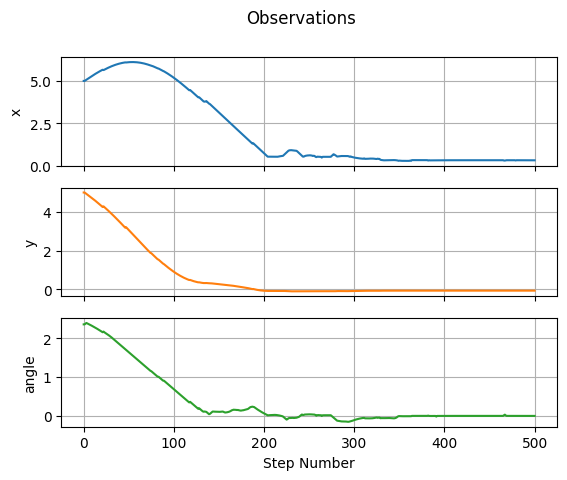

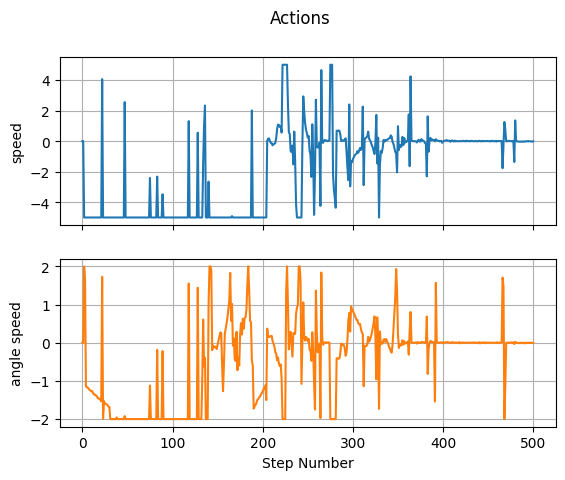

-----------------------------------------------------
Environment solved! Grade: 100%


In [15]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = ThreeWheeledRobotSystem()
step_size = 0.01
## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = Simulator(
    system,
    N_steps=500,
    step_size=step_size,
    state_init=np.array([5.0, 5.0, 3 * np.pi / 4]),
)
# ---------------------------------------------------------------------------
# YOUR CODE GOES HERE
discount_factor = 0.95  # you can change it, but it is not recommended
# ---------------------------------------------------------------------------

model = WeightContainerTorch(
    dim_weights=(1, system.dim_action), action_bounds=[[-5, 5], [-2, 2]]
)
critic_model = ModelPerceptron(
    dim_input=system.dim_observation,
    dim_output=1,
    # --------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    dim_hidden=4,  # TRY TO FIND dim_hidden EMPIRICALLY
    n_hidden_layers=8,  # TRY TO FIND n_hidden_layers EMIRICALLY
    # --------------------------------------------------------------------------
)

critic_optimizer = Optimizer(
    model=critic_model,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_method=torch.optim.Adam, # torch.optim.SGD may work too
    opt_options=dict(lr=1e-2),  # TRY TO FIND lr EMPIRICALLY
    n_epochs=20,  # TRY TO FIND n_epochs EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=False,
)

critic = Critic(
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    td_n=15,  # TRY TO FIND td_n EMPIRICALLY
    batch_size=30,  # TRY TO FIND batch_size EMPIRICALLY
    # ---------------------------------------------------------------------------
    discount_factor=discount_factor,
    device="cpu",
    model=critic_model,
    optimizer=critic_optimizer,
)


policy_optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=1e-2),  # TRY TO FIND lr EMPIRICALLY
    n_epochs=200,  # TRY TO FIND lr EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=True,
)


policy = Policy(
    model=model,
    system=system,
    optimizer=policy_optimizer,
    critic=critic,
    running_cost=compute_running_cost,
    device="cpu",
    discount_factor=discount_factor,
    step_size=step_size,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    epsilon=0.05,  # exploration parameter
    # --------------------------------------------------------------------------
)

scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    discount_factor=discount_factor,
    N_episodes=50,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

# Critic convergence

In this section we provide theoretical evidence for critic convergence. We chosed a perceptron as the critic model for better perfomance. However, for simplicity of mathematical inference we will study the convergence properties of critic model defined as follows:
$$
    \hat{J}^w(y) = w^T \phi(y),
$$
where $\phi(y)$ is the features vector.

**Our main goal** in this section is to derive the sufficient conditions that guarantee convergence of critic's weights $w$ to optimal weights $w^*$ that bestly approximate optimal cost-to-go $J^*(y)$, which is defined as follows:
$$
J^*(y) = \min_{\rho}\left[\sum_{k = 0}^{\infty} \gamma ^ k r(y_k, u_k)\right] \text{ subject to } y_0 = y,
$$

We will learn the model $\hat{J}^w(y) = w^T \phi(y)$ via making gradient step *on every simulation step $k$* based on experience replay $\mathcal{R}_k$, which represents the latest $B$ observations and actions:
$$
    \mathcal{R}_k := \{y_{k - k' + 1}, u_{k - k' + 1}\}_{k'=1}^B
$$

Firslty, let us introduce:
$$
    e_{\text{TD}}(y, u, y') = \hat{J}^w(y) - r(y, u) - \gamma  \hat{J}^w(y')
$$
Secondly, let us represent optimal cost-to-go as follows:
$$
J^*(y) = \hat{J}^{w^*}(y) + e_J(y) = {w^*}^T \phi(y) + e_J(y)
$$
And finally, the weight error
$$
    \tilde{w} = w - w^*
$$

We can express $e_{\text{TD}}(y, u, y')$ in terms of weight error $\tilde{w}$ as follows:
$$
    e^{w}_{\text{TD}}(y, u, y') = \hat{J}^w(y) - r(y, u) - \gamma  \hat{J}^w(y') = w^T(\phi(y) - \gamma \phi(y')) - r(y, u) = \tilde{w}^T(\phi(y) - \gamma \phi(y')) - r(y, u) +  {w^*}^T \phi(y) - \gamma {w^*}^T \phi(y')
$$
Note that
$$
    {w^*}^T \phi(y) = J^*(y) -  e_J(y), \quad {w^*}^T \phi(y') = J^*(y') -  e_J(y')
$$
Thus,
$$
    e^w_{\text{TD}}(y, u, y') = \tilde{w}^T(\phi(y) - \gamma \phi(y')) + J^*(y) - r(y, u) - \gamma J^*(y') - e_J(y) + \gamma e_J(y')
$$
Let us put
$$
    d(y, y') = \phi(y) - \gamma \phi(y'), \quad e^*(y, u, y') = J^*(y) - r(y, u) - \gamma J^*(y')
$$
This notation provide us the following representation for $e_{\text{TD}}(y, u, y')$
$$
    e^{w}_{\text{TD}}(y, u, y') = \tilde{w}^Td(y, y') + e^*(y, u, y')  - e_J(y) + \gamma e_J(y')
$$
Let us define the critic loss as follows
$$
    J_C(w \mid \mathcal{R}_k) := \frac{1}{2} \sum_{k' = k - B + 1}^{k - 1} \frac{e^w_{\text{TD}}(y_{k'}, u_{k'}, y_{k' + 1})^2}{(d_{k'}^Td_{k'} + 1) ^ 2}, \text{ where } d_{k'} = d(y_{k'}, y_{k' + 1})
$$
Thus gradient step looks as follows
$$
    w_{k + 1} \leftarrow w_k - \alpha \nabla_w J_C(w_k \mid \mathcal{R}_k)
$$

Note that
$$
    \nabla_w J_C(w_k \mid \mathcal{R}_k) = \sum_{k' = k - B + 1}^{k - 1} \frac{e^{w_k}_{\text{TD}}(y_{k'}, u_{k'}, y_{k' + 1}) \nabla_w e^{w_k}_{\text{TD}}(y_{k'}, u_{k'}, y_{k' + 1})}{(d_{k'}^Td_{k'} + 1) ^ 2} =  \sum_{k' = k - B + 1}^{k - 1} \frac{e^{w_k}_{\text{TD}}(y_{k'}, u_{k'}, y_{k' + 1}) d_{k'}}{(d_{k'}^Td_{k'} + 1) ^ 2}
$$

Plugging in he full expression for $e^{w_k}_{\text{TD}}$ we get:
$$
    \nabla_w J_C(w_k \mid \mathcal{R}_k) = \sum_{k' = k - B + 1}^{k - 1} \frac{d_{k'} d_{k'} ^ T}{( d_{k'} ^ T d_{k'} + 1 ) ^ 2} \tilde{w}_k +
    \sum_{k' = k - B + 1}^{k - 1} \frac{d_{k'}(e^*(y_{k'}, u_{k'}, y_{k' + 1})  - e_J(y_{k'}) + \gamma e_J(y_{k' + 1}))}{( d_{k'} ^ T d_{k'} + 1 ) ^ 2}
$$
Denote a data matrix:
$$
    D_k = \sum_{k' = k - B + 1}^{k - 1} \frac{d_{k'} d_{k'} ^ T}{( d_{k'} ^ T d_{k'} + 1 ) ^ 2}
$$
And error term:
$$
    C_k =
    \sum_{k' = k - B + 1}^{k - 1} \frac{d_{k'}(e^*(y_{k'}, u_{k'}, y_{k' + 1})  - e_J(y_{k'}) + \gamma e_J(y_{k' + 1}))}{( d_{k'} ^ T d_{k'} + 1 ) ^ 2}
$$
Thus,
$$
    w_{k + 1} = w_k - \alpha D_k \tilde{w}_k - \alpha C_k \Longrightarrow  \tilde{w}_{k + 1} = \tilde{w}_k - \alpha D_k \tilde{w}_k - \alpha C_k
$$
This will give:
$$
\|\tilde{w}_{k + 1}\|^2 - \|\tilde{w}_{k}\|^2 =  \|\tilde{w}_k - \alpha D_k \tilde{w}_k - \alpha C_k\|^2 - \|\tilde{w}_k\|^2 =
 \tilde{w}_k^T (\alpha^2 D_k ^ 2 - 2 \alpha D_k) \tilde{w}_k + O(\|\tilde{w}_k\|)
$$
Let us think of sufficient conditions that guarantee that $\|\tilde{w}_{k + 1}\|^2 - \|\tilde{w}_{k}\|^2 < 0$. Firstly, we need
$$
    \|D_k\| ^ 2 \leq \frac{B}{4}
$$
Secondly, we need persistence of excitation, i. e. positive definiteness of
$$
    D_k - \varepsilon I \geq 0
$$
where $I$ is the identity matrix. This will give us:
$$
    \|\tilde{w}_{k + 1}\|^2 - \|\tilde{w}_{k}\|^2 \leq \left(\alpha^2 \frac{B}{4} - 2\alpha \varepsilon\right) \|\tilde{w}_k\|^2 + O(\|\tilde{w}_k\|)
$$
To make the first term negative we need to assume that $\alpha < \frac{8\eps}{B}$. So, for sufficiently big $\|\tilde{w}_k\|$ we can guarantee that
$$
     \|\tilde{w}_{k + 1}\|^2 - \|\tilde{w}_{k}\|^2 < 0
$$
The optimization step for policy $\rho^{\theta}(y_k)$ should be defined as follows:
$$
    \theta_{k + 1} \la \arg \min_{\theta} (r(y_k, \rho^{\theta}(y_k)) + \gamma \hat{J}^{w_k}(y_{k + 1} ^ {\rho^{\theta}})),
$$
where we denoted $y_{k + 1} ^ {\rho^{\theta}}$ as the observation that is derived via applying action $\rho^{\theta}(y_k)$ to $y_k$.

## Exploration

Critic may fall into local minimum during the optimization procedure. To fight with that we use the approach called exploration. Sometimes we force the agent to make a random action from $\text{Uniform}([v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}])$ to enrich the experience replay. Thus, we generate action $u_k$ on step $k$ according to the following algorithm:

$$
u_k = \begin{cases} \text{Uniform}([v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]), \text{ if } P = 1 \\  
       \arg\left(\min_{\theta}\left(r(y_k, \rho^{\theta}(y)) + \gamma \hat{J}^{w}(y_{k+1}^{\rho^{\theta}(y)})\right)\text{ subject to } \rho^{\theta}(y) \in [v_{\min}, v_{\max}] \times [u_{\min}, u_{\max}]\right), \text{ if } P = 0
    \end{cases},
$$
where $P \sim \text{Bernoulli}(\eps)$ and $\eps$ is small, say, $\eps = 0.05$.